#### track package changes
!pip install --upgrade pandas --> from silent downcasting issue with fillna

!pip install segment-geospatial leafmap --> updates numpy, leafmap messes things up. should downgrade back to 1.23.5. or better yet, don't use this at all, just work in qgis

In [1]:
# !pip install git+https://github.com/thinkingmachines/unicef-ai4d-poverty-mapping.git
# !pip install python-dotenv

# Poverty Mapping and Impact Evaluation

In [51]:
# General
import os
import re
from dotenv import load_dotenv
from pathlib import Path
import gc
import time
import pickle
import math

# Mathematical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# ThinkingMachine utilities
from povertymapping import dhs, nightlights, feature_engineering
import geowrangler.raster_zonal_stats as rzs
import geopandas as gpd
from povertymapping.osm import OsmDataManager, add_osm_poi_features, add_osm_road_features

# Google Earth Engine
import ee
import geemap

# Stats/Machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Deep learning
from torchvision import datasets, models, transforms

# Mapping and images
import rasterio

## Data Sources

https://data.humdata.org/dataset/philippines-high-resolution-population-density-maps-demographic-estimates?#

https://www.ciesin.columbia.edu/repository/hrsl/

## Data

### Label - DHS

We begin by extracting wealth information from the Demographic and Health Survey (DHS) dataset. This will be our label (target) for subsequent model training.

In [13]:
# Directory setup
DEFAULT_CACHE_DIR = "~/.geowrangler"
home_dir = os.path.expanduser('~')

# Set up for extracting relevant data from DHS
COUNTRY_CODE = "ph"                                                    # Philippines as country of interest in this study
DHS_LABEL_COL = "Wealth Index"                                         # Column name as labels for model training
OUTPUT_LABEL_COL = "Wealth_Index"
TILE_SIZE_KM = 2.4                                                     # Tile size as geographic extent for each DHS cluster (unit)

# Paths for DHS material in 2022
DHS_HOUSEHOLD_DTA_PATH_2022 = "data/dhs/ph/PHHR82DT/PHHR82FL.DTA"      # Survey data in dta (stata) format, 2022
DHS_GEOGRAPHIC_SHP_PATH_2022 = "data/dhs/ph/PHGE81FL/PHGE81FL.shp"     # Geographic data (shapefile), 2022

dhs_gdf_2022 = dhs.generate_dhs_cluster_level_data(
    DHS_HOUSEHOLD_DTA_PATH_2022,
    DHS_GEOGRAPHIC_SHP_PATH_2022,
    col_rename_config=COUNTRY_CODE,
    convert_geoms_to_bbox=True,
    bbox_size_km=TILE_SIZE_KM,
).reset_index(drop=True)

# thinkingmachines research suggested minmaxscaler for wealth index at this stage. Reserving til after train test split instead
country_data_2022 = dhs_gdf_2022.copy()
country_data_2022.rename(columns={DHS_LABEL_COL:OUTPUT_LABEL_COL}, inplace=True)
labels_2022 = country_data_2022[['DHSCLUST',OUTPUT_LABEL_COL]]
labels_2022 = labels_2022.set_index('DHSCLUST')

The resulting dataframe `country_data_2022` is a geopandas dataframe, with survey information from each location, including the coordinates of the locations themselves.

In [15]:
country_data_2022.head()

,DHSCLUST,Wealth_Index,DHSID,DHSCC,DHSYEAR,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,...,DHSREGCO,DHSREGNA,SOURCE,URBAN_RURA,LATNUM,LONGNUM,ALT_GPS,ALT_DEM,DATUM,geometry
0,1,-121269.250000,PH202200000001,PH,2022.0,RP,NULL,NULL,NULL,NULL,...,15.0,BARMM - Bangsamoro Autonomous Region in Muslim...,GPS,R,6.716158,122.116863,9999.0,30.0,WGS84,"POLYGON ((122.106 6.72695, 122.12773 6.72695, ..."
1,2,-69178.739130,PH202200000002,PH,2022.0,RP,NULL,NULL,NULL,NULL,...,15.0,BARMM - Bangsamoro Autonomous Region in Muslim...,GPS,U,6.654423,122.130171,9999.0,11.0,WGS84,"POLYGON ((122.11931 6.66521, 122.14104 6.66521..."
2,3,-130489.000000,PH202200000003,PH,2022.0,RP,NULL,NULL,NULL,NULL,...,15.0,BARMM - Bangsamoro Autonomous Region in Muslim...,GPS,R,6.510455,122.122877,9999.0,420.0,WGS84,"POLYGON ((122.11202 6.52125, 122.13374 6.52125..."
3,4,-190052.888889,PH202200000004,PH,2022.0,RP,NULL,NULL,NULL,NULL,...,15.0,BARMM - Bangsamoro Autonomous Region in Muslim...,GPS,R,6.474001,122.058552,9999.0,181.0,WGS84,"POLYGON ((122.04769 6.48479, 122.06941 6.48479..."
4,5,-108371.035714,PH202200000005,PH,2022.0,RP,NULL,NULL,NULL,NULL,...,15.0,BARMM - Bangsamoro Autonomous Region in Muslim...,GPS,R,6.525690,121.873975,9999.0,1.0,WGS84,"POLYGON ((121.86311 6.53648, 121.88484 6.53648..."


The surveyed locations for 2017 are shown by the blue dots in the map below.

In [ ]:
country_data_2022.explore()

### Features - OOKLA, nightlight (satellite), OSM, HRSL, daytime satellite

Next, we retrieve features used for model training:
1. internet speed data from OOKLA;
2. satellite nightlights data from Earth Observation Group (EOG);
3. map data from OpenStreetMap, e.g. distance to amenities, road structure, etc;
4. HRSL population
5. daytime satellite images

#### OOKLA and Nightlight

In [17]:
# Log-in using EOG credentials for nightlight data
env_path = Path.home() / '.env'
load_dotenv(dotenv_path=env_path)
username = os.getenv("EOG_USER")
username = username if username is not None else input("Username?")
password = os.getenv("EOG_PASSWORD", None)
password = password if password is not None else getpass.getpass("Password?")
access_token = nightlights.get_eog_access_token(username, password, save_token=True) # set save_token to True so that access token gets stored in ~/.eog_creds/eog_access_token

2024-08-27 12:01:42.305 | INFO     | povertymapping.nightlights:get_eog_access_token:42 - Saving access_token to /home/tfc/.eog_creds/eog_access_token.txt
2024-08-27 12:01:42.313 | INFO     | povertymapping.nightlights:get_eog_access_token:50 - Adding access token to environment var EOG_ACCESS_TOKEN


In [18]:
# Create features dataframe using generate_features module
ookla_nightlight_2022 = feature_engineering.generate_features(
    country_data_2022,
    country_osm="philippines",
    ookla_year=2022,
    nightlights_year=2022,
    scale=False,
    features_only=True
)

# Keep only OOKLA and nightlight features
ookla_nightlight_features = [col for col in ookla_nightlight_2022.columns if ('fixed' in col) | ('mobile' in col) | ('rad' in col)]
ookla_nightlight_2022 = ookla_nightlight_2022[ookla_nightlight_features]
ookla_nightlight_2022['DHSCLUST'] = country_data_2022['DHSCLUST']
ookla_nightlight_2022 = ookla_nightlight_2022.set_index('DHSCLUST')

2024-08-27 12:01:43.854 | INFO     | povertymapping.osm:download_osm_country_data:198 - OSM Data: Cached data available for philippines at /home/tfc/.geowrangler/osm/philippines? True
2024-08-27 12:01:43.855 | DEBUG    | povertymapping.osm:load_pois:160 - OSM POIs for philippines being loaded from /home/tfc/.geowrangler/osm/philippines/gis_osm_pois_free_1.shp
2024-08-27 12:01:44.842 | INFO     | povertymapping.osm:download_osm_country_data:198 - OSM Data: Cached data available for philippines at /home/tfc/.geowrangler/osm/philippines? True
2024-08-27 12:01:44.843 | DEBUG    | povertymapping.osm:load_roads:179 - OSM Roads for philippines being loaded from /home/tfc/.geowrangler/osm/philippines/gis_osm_roads_free_1.shp
2024-08-27 12:01:50.996 | DEBUG    | povertymapping.ookla:load_type_year_data:79 - Contents of data cache: []
2024-08-27 12:01:50.996 | INFO     | povertymapping.ookla:load_type_year_data:94 - Cached data available at /home/tfc/.geowrangler/ookla/processed/a8fa31ea521ceeb3

#### OSM

In [19]:
# Show all 2022 OSM shapefiles available
osm_datapath_2022 = os.path.join(home_dir,'.geowrangler/osm/','philippines_2022')
sorted([f for f in os.listdir(osm_datapath_2022) if f.endswith('.shp')])

['gis_osm_buildings_a_free_1.shp',
 'gis_osm_landuse_a_free_1.shp',
 'gis_osm_natural_a_free_1.shp',
 'gis_osm_natural_free_1.shp',
 'gis_osm_places_a_free_1.shp',
 'gis_osm_places_free_1.shp',
 'gis_osm_pofw_a_free_1.shp',
 'gis_osm_pofw_free_1.shp',
 'gis_osm_pois_a_free_1.shp',
 'gis_osm_pois_free_1.shp',
 'gis_osm_railways_free_1.shp',
 'gis_osm_roads_free_1.shp',
 'gis_osm_traffic_a_free_1.shp',
 'gis_osm_traffic_free_1.shp',
 'gis_osm_transport_a_free_1.shp',
 'gis_osm_transport_free_1.shp',
 'gis_osm_water_a_free_1.shp',
 'gis_osm_waterways_free_1.shp']

In [20]:
# Show features contained in each shapefile
all_files = sorted([f for f in os.listdir(osm_datapath_2022) if f.endswith('.shp')])
for f in all_files:
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print(f)
    filepath = os.path.join(osm_datapath_2022,f)
    gdf = gpd.read_file(filepath)
    print(gdf.fclass.unique())
    print()

~~~~~~~~~~~~~~~~~~~~~~~~~~
gis_osm_buildings_a_free_1.shp
['building']

~~~~~~~~~~~~~~~~~~~~~~~~~~
gis_osm_landuse_a_free_1.shp
['retail' 'park' 'grass' 'cemetery' 'industrial' 'commercial'
 'residential' 'forest' 'recreation_ground' 'farmland' 'scrub' 'military'
 'nature_reserve' 'meadow' 'quarry' 'farmyard' 'heath' 'allotments'
 'orchard' 'vineyard']

~~~~~~~~~~~~~~~~~~~~~~~~~~
gis_osm_natural_a_free_1.shp
['beach' 'cliff' 'spring' 'tree' 'cave_entrance']

~~~~~~~~~~~~~~~~~~~~~~~~~~
gis_osm_natural_free_1.shp
['tree' 'cave_entrance' 'peak' 'spring' 'cliff' 'beach' 'volcano']

~~~~~~~~~~~~~~~~~~~~~~~~~~
gis_osm_places_a_free_1.shp
['island' 'village' 'hamlet' 'locality' 'farm' 'town' 'city' 'suburb']

~~~~~~~~~~~~~~~~~~~~~~~~~~
gis_osm_places_free_1.shp
['suburb' 'city' 'town' 'hamlet' 'village' 'national_capital' 'island'
 'locality' 'farm' 'region' 'county']

~~~~~~~~~~~~~~~~~~~~~~~~~~
gis_osm_pofw_a_free_1.shp
['christian' 'christian_catholic' 'jewish' 'christian_evangelical'
 'bud

Based on the features above, we select the following shapefiles to include in our analysis:
- `gis_osm_pois_free_1.shp` for points of interest
- `gis_osm_transport_free_1.shp` and `gis_osm_traffic_free_1.shp` for transport related amenities

This is a departure from the original features selected by ThinkingMachine, which were all extracted in `gis_osm_pois_free_1.shp` and hardcoded in the `osm.add_osm_poi_features` function as such. For simplicity and to avoid making changes to the base code, we include information from the `other shapefiles` into `gis_osm_pois_free_1.shp` below.

In [21]:
# Combine shapefiles to replace gis_osm_pois_free_1.shp
required_shapefiles = ['gis_osm_pois_free_1.shp',             # Shapefiles to combine
                       'gis_osm_transport_free_1.shp',
                       'gis_osm_traffic_free_1.shp']
gdfs = [gpd.read_file(os.path.join(osm_datapath_2022,shapefile)) for shapefile in required_shapefiles]
gdfs[0].to_file('gis_osm_pois_free_1_original.shp')           # Make backup of original gis_osm_pois_free_1.shp file
combined_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
combined_gdf.to_file('gis_osm_pois_free_1.shp')               # Replace original file

We can now proceed to generate the required points of interest features for the dataset. The `OSM.add_osm_poi_features` function is used for this.

In [22]:
# Instantiate data managers for OSM
osm_data_manager = OsmDataManager(cache_dir=DEFAULT_CACHE_DIR)
country_osm = "philippines_2022"

# Get OSM point features
OSM_poi_features = add_osm_poi_features(
    country_data_2022, country_osm, osm_data_manager, poi_types = combined_gdf.fclass.unique(), use_cache=True
)
OSM_poi_features = OSM_poi_features[[col for col in OSM_poi_features.columns if not (col in country_data_2022.columns)]]
OSM_poi_features['DHSCLUST'] = country_data_2022['DHSCLUST']
OSM_poi_features = OSM_poi_features.set_index('DHSCLUST')

2024-08-27 12:02:25.694 | INFO     | povertymapping.osm:download_osm_country_data:198 - OSM Data: Cached data available for philippines_2022 at /home/tfc/.geowrangler/osm/philippines_2022? True
2024-08-27 12:02:25.694 | DEBUG    | povertymapping.osm:load_pois:160 - OSM POIs for philippines_2022 being loaded from /home/tfc/.geowrangler/osm/philippines_2022/gis_osm_pois_free_1.shp


Next, we include road related features using `osm.add_osm_road_features` function.

In [23]:
# Get OSM road features
OSM_road_features = add_osm_road_features(
    country_data_2022, country_osm, osm_data_manager, use_cache=True
)
OSM_road_features = OSM_road_features[[col for col in OSM_road_features.columns if not (col in country_data_2022.columns)]]
OSM_road_features['DHSCLUST'] = country_data_2022['DHSCLUST']
OSM_road_features = OSM_road_features.set_index('DHSCLUST')

2024-08-27 12:02:30.078 | INFO     | povertymapping.osm:download_osm_country_data:198 - OSM Data: Cached data available for philippines_2022 at /home/tfc/.geowrangler/osm/philippines_2022? True
2024-08-27 12:02:30.079 | DEBUG    | povertymapping.osm:load_roads:179 - OSM Roads for philippines_2022 being loaded from /home/tfc/.geowrangler/osm/philippines_2022/gis_osm_roads_free_1.shp


#### HRSL

The High Resolution Settlement Layer (HRSL) by Meta contains information on human settlement. Data for 2015 and 202 are publicly available. We load the 2020 one here.

In [24]:
# Get 2020 population information
path_2020_pop_general = Path('data/hrsl/phl_general_2020.tif')
features_pop_2020 = rzs.create_raster_zonal_stats(
    country_data_2022,
    path_2020_pop_general,
    aggregation=dict(output="pop_gen", func="mean")
)
features_pop_2020 = features_pop_2020[['DHSCLUST','pop_gen']]
features_pop_2020 = features_pop_2020.set_index('DHSCLUST')

#### Daytime Satellite Images

There are multiple sources for daytime satellite images. We prefer open-source data that require minimal GIS expertise and pre-processing, and has historical record over multiple years. Different approaches were explored:
1. Downloading Sentinel-2 (harmonized) images from [Google Earth Engine](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED) via `geemap` package - good quality data at 10m resolution, but requires moderate pre-processing efforts including:
    a. Removal of cloud covers
    b. Histogram matching or other techniques to match band values across different image tiles and years
2. Downloading high resolution image from Google Maps - using [Google Maps Static API] for high resolution images at 1m resolution (https://developers.google.com/maps/documentation/maps-static/overview) `googlemaps`. However, this approach is not free and only the latest satellite image is available (i.e. no historical records or data dumps available).
3. High quality (16-bit) Sentinel-2 images from EOX - preprocessed Sentinel 2 images to remove cloud cover, with images from multiple years available, but is not free
4. Moderate quality (8-bit) Sentinel-2 images from EOX - via Web Map Service (WMS), similarly preprocessed to remove cloud, and is freely available, easily accessible through GIS softwares.

Here, we use approach 4, in view of the consistency in data quality and format across the years, and cost considerations. We use QGIS to extract the required images. [QGIS](https://www.qgis.org/), an open-source GIS software, will be used to access the EOX furnished cloudless Sentinel-2 images.

The geopandas dataframe above `dhs_gdf_2022` contains the geometries of the required images for training, giving their location as well as extent (2.4km x 2.4km corresponding to 240 x 240 pixels). We export these geometries as a vector shapefile, which will be used in QGIS later for image extraction. The EPSG:4326 CRS is used here without any reprojection for simplicity.

In [ ]:
shape_path = '/data/daysat/2022/dhs_shapes'
shape_name = 'phil_2022_extents_epsg4326.shp'
shape_file = os.path.join(shape_path,shape_name)
country_data_2022.to_file(shape_file)

QGIS comes with the Python console pre-installed. We can run the helper script `qgis_export_wms_as_tif_tiles.py` in the helpers folder in the QGIS Python console to extract the required images. The script is reproduced below for reference.

In [ ]:
import os
from qgis.core import QgsProject, QgsMapSettings, QgsMapRendererParallelJob, QgsMapLayerType
from PyQt5.QtCore import QSize
import time

'''
Automates image export from QGIS for EOX cloudless Sentinel-2 map.
Note: Clip raster by mask layer does not work for WMS maps
'''

## INPUT
daysat_folder = "data/daysat/2022/"          # Define output folder
shape_name = "phil_2022_extends_epsg4326"    # Define shape name for clipping image tiles from map
map_name = "Sentinel-2 cloudless layer for 2022 by EOX - 4326"      # Define name of Sentinel-2 map layer loaded in QGIS

# Create output folder if it does not exist
if not os.path.exists(daysat_folder):
    os.makedirs(daysat_folder)

# Load the vector layer defining extents
extent_layer = QgsProject.instance().mapLayersByName(shape_name)[0]

# Load raster layer of EOX cloudless Sentinel-2 basemap via WMS
sentinel2_layer = QgsProject.instance().mapLayersByName(map_name)[0]

# Prepare the QGIS map settings
def setup_map_settings():
    map_settings = QgsMapSettings()
    map_settings.setLayers([sentinel2_layer])
    map_settings.setOutputSize(QSize(240, 240)) # Setting output at 240 by 240 pixels
    return map_settings

map_settings = setup_map_settings()

def export_feature(feature):
    try:
        geom = feature.geometry()
        extent = geom.boundingBox()
        map_settings.setExtent(extent)

        output_file = os.path.join(daysat_folder, f"map_{feature.id()}.tif")

        # Adjust output size based on extent
        map_settings.setOutputSize(QSize(240, 240)) # Setting output at 240 by 240 pixels

        # Render the map
        render_job = QgsMapRendererParallelJob(map_settings)
        render_job.start()
        render_job.waitForFinished()

        image = render_job.renderedImage()
        image.save(output_file,"tif")

#         print(f"Exported {output_file}")
    except Exception as e:
        print(f"Failed to export feature {feature.id()}: {e}")

# Process each feature sequentially
for i,feature in enumerate(extent_layer.getFeatures()):
    export_feature(feature)
    if i%100==0:
        print(f'At image {i} of len(extent_layer.getFeatures())')
        time.sleep(5)

print("Export completed.")

The resulting images have four bands, with the first three corresponding to R, G, B. We keep only these first three bands.

In [23]:
# Keep only RGB bands
original_daysat_folder = "data/daysat/2022/"
temp_daysat_folder = "data/daysat/2022_temp/"
original_tifs = [f for f in os.listdir(daysat_folder) if f.lower().endswith('.tif')]

# Create the directory if it doesn't exist
os.makedirs(temp_daysat_folder, exist_ok=True)

# Iterate through each file and corresponding axis
for tif in original_tifs:
    original_tif_path = os.path.join(original_daysat_folder, tif)
    temp_tif_path = os.path.join(temp_daysat_folder, tif)

    with rasterio.open(original_tif_path) as src:
        # Check if the file has at least 3 bands
        if src.count < 3:
            raise ValueError("The file has fewer than 3 bands.")
    
        bands_data = src.read([1, 2, 3])                      # Read the first 3 bands
        profile = src.profile                                 # Write the first 3 bands to a temporary file
        profile.update(count=3)                               # Update the profile to only have 3 bands
        
        with rasterio.open(temp_tif_path, 'w', **profile) as dst:
            dst.write(bands_data)

    # Replace the original file with the new file
    os.replace(temp_tif_path,original_tif_path)

Some sample images extracted this way are show below

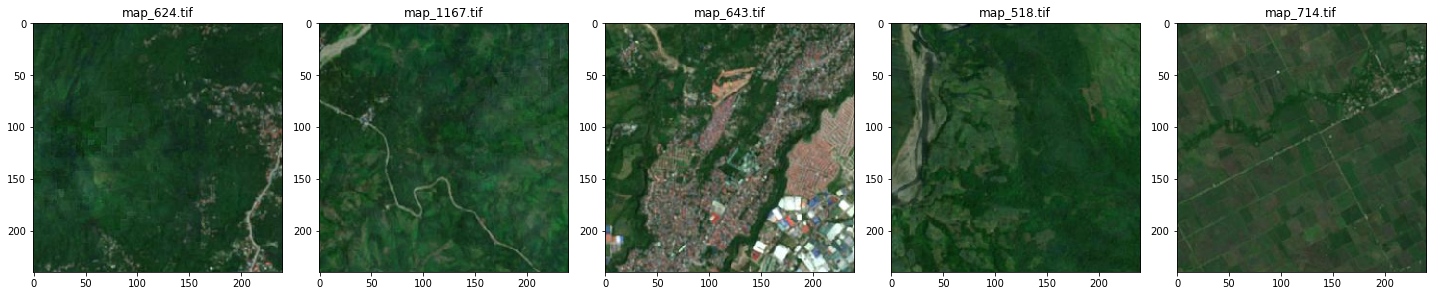

In [24]:
# Sample 5 tif images to display
daysat_folder = "data/daysat/2022/"
all_tif_files = [f for f in os.listdir(daysat_folder) if f.lower().endswith('.tif')]
sampled_files = random.sample(all_tif_files, 5)
sampled_file_paths = [os.path.join(daysat_folder, f) for f in sampled_files]

# Plot
fig, axes = plt.subplots(1,5,figsize=(20, 5))

# Iterate through each file and corresponding axis
for ax, tif_file in zip(axes, sampled_file_paths):
    with rasterio.open(tif_file) as src:
        bands = [src.read(i) for i in range(1, src.count + 1)]
        rgb_image = np.stack([bands[0], bands[1], bands[2]], axis=-1)  # RGB
        ax.imshow(rgb_image)
        ax.set_title(tif_file.split('/')[-1])
        
fig.tight_layout()

## Model Training

Here, we consider different models for training, as well as different combinations of input data. The goal is to predict the scaled wealth index obtained from DHS.

### XGBoost + OOKLA, nightlight, OSM, and HRSL

In [28]:
# Gathering all tabular data (i.e. everything except daytime sat images)
datapath = "data/"
y = labels_2022.copy()
X = pd.concat([ookla_nightlight_2022,OSM_poi_features,OSM_road_features,features_pop_2020],axis=1)

# Export to csv
X.to_csv(os.path.join(datapath,'X.csv'))
y.to_csv(os.path.join(datapath,'y.csv'))

In [49]:
# Create train test split and min max scale labels as recommended by thinkingmachines
X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.20, random_state=42)
scaler = MinMaxScaler()
y_train = scaler.fit_transform(y_train)
y_val = scaler.transform(y_val)
y_test = scaler.transform(y_test)

Testing performance
MSE: 0.0159


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

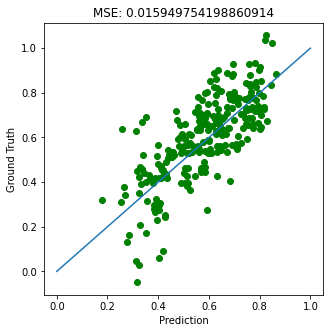

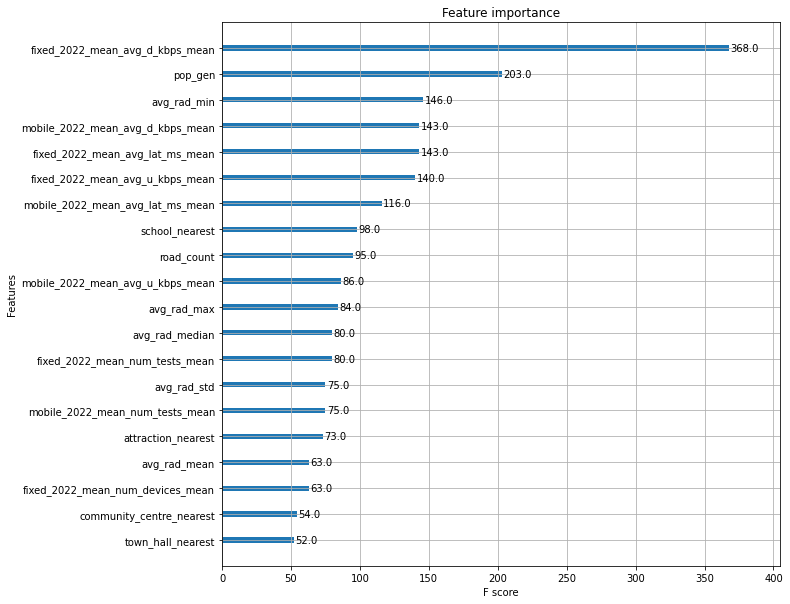

In [50]:
# After quick grid search below
params = {
    'learning_rate': 0.1,
    'n_estimators': 100,
    'max_depth': 6,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 1,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 0,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'device':'cuda',
    'tree_method':'hist',
    # 'enable_categorical':True
}

model_xgb_base = xgb.XGBRegressor(**params)
model_xgb_base.fit(pd.concat([X_train,X_val],axis=0), np.vstack([y_train,y_val]))

# model_xgb_reg.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
pred = model_xgb_base.predict(X_test)
mse = mean_squared_error(y_test,pred)
print('Testing performance')
print(f'MSE: {mse:.4f}')

fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(pred,y_test, c='g')
ax.plot([0,1],[0,1])
ax.set_title(f'MSE: {mse}')
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth');

fig2, ax2 =plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(model_xgb_base,max_num_features=20,ax=ax2)

In [15]:
# grid search
from itertools import product

all_params = {'learning_rate' : [0.05,0.1,0.2],
              'n_estimators' : [50,100,500],
              'max_depth' : [5,6,7],
              'min_child_weight' : [1,1.2],
              'gamma' : [0,0.2],
              'subsample':[0.8,1],
              'colsample_bytree' : [0.8,1],
              'reg_lambda' : [0,1],
              'reg_alpha' : [0,1],
              'objective': ['reg:squarederror'],
              'random_state': [42],
              'device':['cuda'],
              'tree_method':['hist'],
              'enable_categorical':[True]}

# Generate all combinations of parameters
keys = all_params.keys()
combinations = list(product(*all_params.values()))

# Create a list of dictionaries for each combination
all_params = [dict(zip(keys, combination)) for combination in combinations]
counter=0
with open(os.path.join('Junk','gs_xgb_base.txt'),'a') as f:
    for params in all_params:
        counter += 1
        model_xgb_base = xgb.XGBRegressor(**params)
        model_xgb_base.fit(X_train, y_train)

        # Evaluation
        # model_xgb_reg.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
        pred = model_xgb_base.predict(X_val)
        mse = mean_squared_error(y_val,pred)
        outstring = f'{params}, mse: {mse}\n'
        print(f'\n\nIteration {counter} of {len(all_params)}')
        print(outstring)
        f.write(outstring)
        f.flush()

/home/tfc/anaconda3/envs/poverty_mapping/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:57:55] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)




Iteration 1 of 1728
{'learning_rate': 0.05, 'n_estimators': 50, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_lambda': 0, 'reg_alpha': 0, 'objective': 'reg:squarederror', 'random_state': 42, 'device': 'cuda', 'tree_method': 'hist', 'enable_categorical': True}, mse: 0.010472807192969209



Iteration 2 of 1728
{'learning_rate': 0.05, 'n_estimators': 50, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_lambda': 0, 'reg_alpha': 1, 'objective': 'reg:squarederror', 'random_state': 42, 'device': 'cuda', 'tree_method': 'hist', 'enable_categorical': True}, mse: 0.010449565904928817



Iteration 3 of 1728
{'learning_rate': 0.05, 'n_estimators': 50, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'objective': 'reg:squarederror', 'random_state': 42, 'device': 'cuda', 'tree_method': 'hist', 'enable_categorical': True}

In [16]:
# Read the file and extract the data
data=[]
with open('gs_xgb_base.txt', 'r') as file:
    all_lines = file.readlines()

    for line in all_lines:
    #     # # Split each line into key-value pairs
        line = line.replace("'", "").replace("}", "").replace("{", "").replace("reg:squarederror","regsquarederror").strip('\n')
        pairs = line.split(',')
        entry = {}
        for pair in pairs:
            pair = pair.strip()
            key, value = pair.split(':')
            key = key.strip()
            value = value.strip()
            entry[key] = value
        data.append(entry)

df_gs_xgb_base = pd.DataFrame(data)
df_gs_xgb_base.iloc[:,:9] = df_gs_xgb_base.iloc[:,:9].astype('float')
df_gs_xgb_base.iloc[:,-1] = df_gs_xgb_base.iloc[:,-1].astype('float')

n_estimators
learning_rate
min_child_weight
max_depth
gamma
subsample
colsample_bytree
reg_lambda
reg_alpha


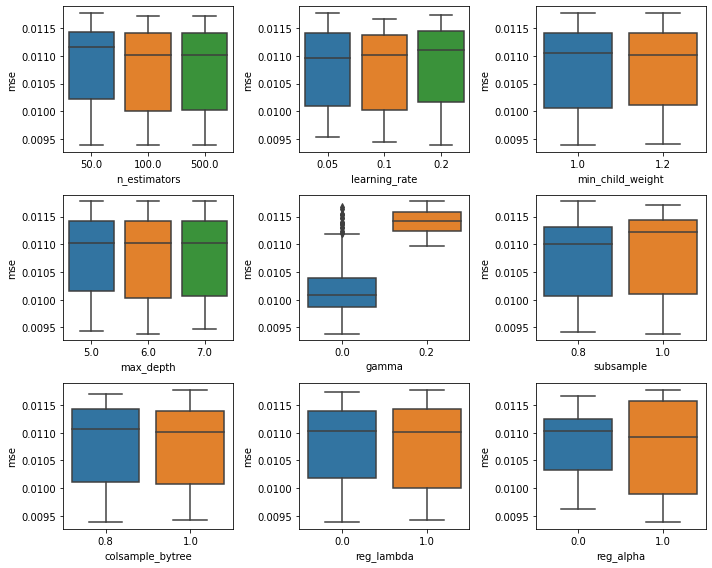

In [17]:
feats = ['n_estimators', 'learning_rate', 'min_child_weight',
         'max_depth', 'gamma','subsample',
         'colsample_bytree','reg_lambda','reg_alpha']
fig, axs = plt.subplots(3,3,figsize=(10,8))
axs=axs.flatten()
for i,param in enumerate(feats):
    print(param)
    sns.boxplot(df_gs_xgb_base,x=param,y='mse',ax=axs[i])

fig.tight_layout()

### XGBoost + OOKLA, daysat features trained on nightlight (convnextv2), OSM, and HRSL

### XGBoost + OOKLA, daysat features trained on nightlight (resnet101), OSM, and HRSL

### XGBoost + OOKLA, daysat features trained on nightlight (vit_base), OSM, and HRSL

### convnextv2 on daysat + other features

### resnet101 on daysat + other features

### vit_base on daysat + other features

## Get Prediction Set

In [ ]:
from povertymapping.iso3 import get_region_name
from povertymapping.rollout_grids import get_region_filtered_bingtile_grids

In [ ]:
COUNTRY_CODE = "ph"
REGION = get_region_name(COUNTRY_CODE, code="alpha-2").lower()
ADMIN_LVL = "ADM2"
ZOOM_LEVEL = 14

In [ ]:
admin_grids_gdf = get_region_filtered_bingtile_grids(
    REGION, admin_lvl=ADMIN_LVL, quadkey_lvl=ZOOM_LEVEL, use_cache=False,
)

In [ ]:
pred_grid_file = 'phil_grids_2022'
rollout_date = "-".join(os.getcwd().split("/")[-2].split("-")[:3])
grid_save_path = f"./{rollout_date}-{COUNTRY_CODE}-rollout-grids.geojson"
admin_grids_gdf.to_file(grid_save_path, driver="GeoJSON", index=False)